In [9]:
import numpy as np
import pandas as pd
import plotnine as p9; p9.theme_set(p9.theme_bw())
from pandasql import sqldf as sql
import cvxpy as cp
import multiprocessing as mp
from multiprocessing.pool import ThreadPool
import itertools as it
from sklearn.model_selection import StratifiedKFold

In [10]:
mp.cpu_count()

12

In [11]:
print(cp.installed_solvers())

['ECOS', 'ECOS_BB', 'OSQP', 'SCIPY', 'SCS']


### Data

Have vectors of observations $Y_i \in \Re^{L}$

### Objectives to Estimate Betas

$$
\hat{\beta}(\Alpha) = \argmax_{\beta}\ \left( \frac{1}{n_t} \sum_{contact_i=1} Y_i - \frac{1}{n_c} \sum_{contact_i=0} Y_i \right)\beta  - \lambda \cdot \beta \Alpha \beta^T
$$

$\hat{\beta}_{DM} = \hat{\beta}(I_{LxL})$

$\hat{\beta}_{LR} = \hat{\beta}\left(\frac{1}{n}\sum_{i=1}^{n}(Y_i - \bar{Y})(Y_i - \bar{Y})^T\right)$

Constraint (enforced later)

$||\beta||_2 = 1$

### Simulations

Steps:
1. Sample large observational dataset
2. Sample small experimental dataset
3. Estimate beta in a few different ways:
    1. Estimate beta with DM and LR fn on obs data
    2. Estimate beta with DM and LR fn on exp data (cross-fit)
4. Estimate alpha and SE(alpha) in the experimental dataset with the following betas:
    1. All those estimated in Step #3
    2. "Null" beta (mean of all Y dimensions)
    3. "Oracle" beta (true beta)

Simulation Parameters:
* N obs in experimental dataset
* N obs in observational dataset / N obs in experimental dataset
* N dimensions in outcome [higher number -> more sparsity, since I will just set beta=1 in the first dimension for now and beta=0 in all the others]
* Alpha (treatement effect in dims with beta==1)
* SD in affected dimensions / Alpha [higher value makes it harder to est beta]
* SD in unaffected dimensions / SD in affected dimensions [higher value makes logistic objective outperform linear objective]

In [12]:
def dgp2(s, n, tau, sd_a, sd_u, n_dims):
  
    np.random.seed(s)

    # Make beta==1 in just the first dim
    true_beta = np.concatenate((np.array([1]), np.repeat(0, n_dims-1)))

    # Define SD
    sd_y = np.concatenate((np.array([sd_a*tau]), np.repeat(sd_u*sd_a*tau, n_dims-1)))

    # Sample errors and contacts
    epsilons = np.random.normal(scale=np.tile(sd_y, (n,1)), size=(n,n_dims))
    contact = np.random.binomial(1, 0.5, size=n)
    

    e_y = np.outer(np.expand_dims(contact,1), true_beta) * tau
    y = e_y + epsilons

    return((
      e_y,
      y,
      contact,
      true_beta
    ))


# Verify alpha is as expected using true beta to estimate
N_SIMS = 20
N_DIMS = [3, 5, 10]
est_taus = []
for ndims in N_DIMS:
    for s in range(N_SIMS):
        _, y, c, true_beta = dgp2(s, 100, 1, 2, 2, ndims)
        y_trans = y @ true_beta
        est_tau = np.mean(y_trans[c==1]) - np.mean(y_trans[c==0])
        est_taus.append((ndims, 'true beta', est_tau))

        # also estimate with uniform beta
        est_alpha_null = np.mean(y[c==1]) - np.mean(y[c==0])
        est_taus.append((ndims, 'uniform null beta', est_alpha_null))

est_taus_df = pd.DataFrame(est_taus, columns=['n_dims', 'type', 'est_tau'])
est_taus_df.groupby(['n_dims','type'])[['est_tau']].agg(['mean', 'std'])

est_tau          
                              mean       std
n_dims type                                 
3      true beta          0.986497  0.339331
       uniform null beta  0.326724  0.571491
5      true beta          0.986999  0.371103
       uniform null beta  0.065534  0.314101
10     true beta          0.964560  0.321570
       uniform null beta  0.093016  0.215141

In [13]:
# Estimate beta_DM (closed form)
def est_beta_DM(y, c):
    Y_contact = y[c==1,:]
    Y_no_contact = y[c==0,:]
    est_beta = np.mean(Y_contact, axis=0) - np.mean(Y_no_contact, axis=0)
    # normalize so L2 norm equal to 1
    est_beta = est_beta / np.linalg.norm(est_beta, 2)
    return(est_beta)

# Test
_, y, c, true_beta = dgp2(1, 100, 2, 2, 2, 3)
est_beta_DM(y, c)

array([0.76801308, 0.2155958 , 0.6030542 ])

In [14]:
# Estimate beta_LR (closed form)
def est_beta_LR(y, c):
    Y_contact = y[c==1,:]
    Y_no_contact = y[c==0,:]
    est_beta = (np.mean(Y_contact, axis=0) - np.mean(Y_no_contact, axis=0))/np.var(y, axis=0)
    # normalize so L2 norm equal to 1
    est_beta = est_beta / np.linalg.norm(est_beta, 2)
    return(est_beta)

# Test
_, y, c, true_beta = dgp2(1, 100, 2, 2, 2, 3)
est_beta_LR(y, c)

array([0.96687296, 0.0812757 , 0.24197303])

In [15]:
# One fn for both beta estimators
def estimate_beta(y, c, estimator):
    match estimator:
        case "DM": return(est_beta_DM(y,c))
        case "LR": return(est_beta_LR(y,c))
        case other: raise Exception(f"Estimator not implemented: {estimator}")

_, y, c, true_beta = dgp2(1, 100, 2, 2, 2, 3)
print(estimate_beta(y,c, "DM"))
print(estimate_beta(y,c, "LR"))
# print(estimate_beta(y,c, "NN"))

[0.76801308 0.2155958  0.6030542 ]
[0.96687296 0.0812757  0.24197303]


In [16]:
# Function to estimate beta and Y_beta with cross-fitting
def cross_fit_beta_est_and_est_y_beta(k_folds, y, c, estimator):
    kf = StratifiedKFold(n_splits=k_folds)
    n_dims = y.shape[1]
    est_betas = [np.zeros(n_dims)] * y.shape[0]
    Y_betas = np.zeros(y.shape[0])
    for i, (train_index, test_index) in enumerate(kf.split(y, c)):
        est_b_for_fold = estimate_beta(y[train_index], c[train_index], estimator)
        Y_betas[test_index] = y[test_index] @ est_b_for_fold
    return(Y_betas)

# Test
_, y, c, true_beta = dgp2(s, 50, 2, 2, 1, 3)
cross_fit_beta_est_and_est_y_beta(10, y, c, "LR")

array([-2.89124595,  1.86165732, -4.30505562,  6.92156312,  2.0826    ,
       -0.33387639, -1.49308652, -4.48959395, -0.37548253,  2.57788462,
        7.82917014,  0.41354738,  6.00947823,  3.07729566, -2.3967473 ,
        0.5189351 ,  0.69390574, -1.37190795, -1.61133555, -3.83837788,
       -0.71042809, -3.71996882, -0.99085625, -0.50556137,  1.41134879,
       -0.26932036, -4.38828544, -4.00828036, -0.53279453,  4.66654514,
       -2.99490167, -1.79294877, -1.75945017, -6.36586465, -4.23694387,
       -4.28601444,  6.58638258,  4.40969751,  2.27671509, -5.87633349,
        5.73568615,  1.190018  , -0.06285016, -2.04121354,  2.06412284,
        4.14594307, -0.87588112, -2.77172005, -0.62462653,  1.62059184])

In [17]:
# Function to estimate tau and its SE
def est_tau(ndims, y_betas, c):
    est = (np.mean(y_betas[c==1]) - np.mean(y_betas[c==0]))
    se = np.sqrt(np.var(y_betas[c==1])/np.sum(c==1) + np.var(y_betas[c==0])/np.sum(c==0))
    return((est, se))

# Test
_, y, c, true_beta = dgp2(1, 1000, 1, 1, 1, 3)
est_tau(3, cross_fit_beta_est_and_est_y_beta(10, y, c, "LR"), c)

(0.9944391147859556, 0.06220905654579498)

In [23]:
# Function generate taus using all the different betas we want to compare
def gen_taus_w_different_betas(
    seed,
    k_folds,
    exp_sample_size,
    rel_obs_sample_size,
    tau,
    sd_a, 
    sd_u,
    n_dims
):

    ##########################################################
    # Gen obs and exp data
    ##########################################################
    _, y_obs, c_obs, _ = dgp2(seed, exp_sample_size*rel_obs_sample_size, tau, sd_a, sd_u, n_dims)
    _, y_exp, c_exp, true_beta = dgp2(seed*2, exp_sample_size, tau, sd_a, sd_u, n_dims)


    ##########################################################
    # Gen alpha w oracle and null betas
    ##########################################################
    oracle_tau, oracle_tau_se = est_tau(n_dims, y_exp @ true_beta, c_exp)
    null_beta = np.repeat(1, n_dims)
    null_beta = null_beta / np.linalg.norm(null_beta, 2)
    null_tau, null_tau_se = est_tau(n_dims, y_exp @ null_beta, c_exp)

    # Generate output DF for oracle and null betas
    oracle_null_df = pd.DataFrame({
      'seed': np.repeat(seed, 2),
      'method': ['oracle', 'null'],
      'est_tau': [oracle_tau, null_tau],
      'est_tau_se': [oracle_tau_se, null_tau_se]
    })

    ##########################################################
    # Estimate alphas using betas fit on observational data
    ##########################################################
    obs_beta_dm = estimate_beta(y_obs, c_obs, "DM")
    obs_beta_lr = estimate_beta(y_obs, c_obs, "LR")
    obs_beta_dm_tau, obs_beta_dm_tau_se = est_tau(n_dims, y_exp @ obs_beta_dm, c_exp)
    obs_beta_lr_tau, obs_beta_lr_tau_se = est_tau(n_dims, y_exp @ obs_beta_lr, c_exp)

    # Generate output DF for observational data betas
    obs_df = pd.DataFrame({
      'seed': np.repeat(seed, 2),
      'method': ['obs beta (DM)', 'obs beta (LR)'],
      'est_tau': [obs_beta_dm_tau, obs_beta_lr_tau],
      'est_tau_se': [obs_beta_dm_tau_se, obs_beta_lr_tau_se]
    })

    ##########################################################
    # Estimate alphas using betas cross-fit on experimental data
    ##########################################################
    exp_dm_cf_y_beta = cross_fit_beta_est_and_est_y_beta(k_folds, y_exp, c_exp, "DM")
    exp_lr_cf_y_beta = cross_fit_beta_est_and_est_y_beta(k_folds, y_exp, c_exp, "LR")
    exp_beta_dm_tau, exp_beta_dm_tau_se = est_tau(n_dims, exp_dm_cf_y_beta, c_exp)
    exp_beta_lr_tau, exp_beta_lr_tau_se = est_tau(n_dims, exp_lr_cf_y_beta, c_exp)

    # Generate output DF for experimental data betas
    exp_df = pd.DataFrame({
      'seed': np.repeat(seed, 2),
      'method': ['exp beta (DM)', 'exp beta (LR)'],
      'est_tau': [exp_beta_dm_tau, exp_beta_lr_tau],
      'est_tau_se': [exp_beta_dm_tau_se, exp_beta_lr_tau_se]
    })

    return(pd.concat([oracle_null_df, obs_df, exp_df]))


# Test
gen_taus_w_different_betas(1, 10, 100, 10, 1, 4, 2, 3)

,seed,method,est_tau,est_tau_se
0,1,oracle,2.685628,0.854633
1,1,null,4.889293,1.383849
0,1,obs beta (DM),1.701718,1.064675
1,1,obs beta (LR),2.463732,0.843804
0,1,exp beta (DM),4.292131,1.425238
1,1,exp beta (LR),3.818547,1.037331


In [43]:
# Create tuples of parameters to run in parallel
N_SIMS = 500
K_FOLDS = 10
EXP_SAMPLE_SIZE = 100
TAU = 1

N_DIMS = [3, 5, 10]
REL_OBS_SAMPLE_SIZES = [10]
SD_A = [2]
SD_U = [1, 2, 4, 6, 8, 10]

param_grid = it.product(
    range(N_SIMS),
    REL_OBS_SAMPLE_SIZES,
    SD_A,
    SD_U,
    N_DIMS
)

# Fun to run sims given params and return dataframe
def run_sim(params):
    s, rel_obs_sample_size, sd_a, sd_u, n_dims = params
    df = gen_taus_w_different_betas(s, K_FOLDS, EXP_SAMPLE_SIZE, rel_obs_sample_size, TAU, sd_a, sd_u, n_dims)
    df['exp_sample_size'] = EXP_SAMPLE_SIZE
    df['rel_obs_sample_size'] = rel_obs_sample_size
    df['tau'] = TAU
    df['sd_a'] = sd_a
    df['sd_u'] = sd_u
    df['n_dims'] = n_dims
    return(df)

# Test
run_sim((1, 10, 4, 4, 3))

,seed,method,est_tau,est_tau_se,exp_sample_size,rel_obs_sample_size,tau,sd_a,sd_u,n_dims
0,1,oracle,2.685628,0.854633,100,10,1,4,4,3
1,1,null,8.228037,2.640555,100,10,1,4,4,3
0,1,obs beta (DM),0.111244,2.598889,100,10,1,4,4,3
1,1,obs beta (LR),2.491715,0.853388,100,10,1,4,4,3
0,1,exp beta (DM),7.400619,3.077881,100,10,1,4,4,3
1,1,exp beta (LR),4.116080,1.115658,100,10,1,4,4,3


In [44]:
# Run sims for each params in parallel
with ThreadPool() as pool:
    results = pool.map(run_sim, param_grid, chunksize=4)

In [ ]:
results_df = pd.concat(results)

# Est z scores
results_df['z'] = results_df['est_tau']/results_df['est_tau_se']
results_df['stat_sig'] = np.where(results_df['z']>1.96,1,0)

# Power by method
agg_results = results_df.groupby(['exp_sample_size','rel_obs_sample_size','tau','sd_a','sd_u','n_dims','method'])[['est_tau','est_tau_se','stat_sig']].mean().reset_index()

# Add conf interval
agg_results['se'] = np.sqrt(agg_results['stat_sig']*(1-agg_results['stat_sig'])/N_SIMS)
agg_results['lb'] = agg_results['stat_sig'] - 1.96*agg_results['se']
agg_results['ub'] = agg_results['stat_sig'] + 1.96*agg_results['se']

agg_results.head()

,exp_sample_size,rel_obs_sample_size,tau,sd_a,sd_u,n_dims,method,est_tau,est_tau_se,stat_sig,se,lb,ub
0,100,10,1,2,1,3,exp beta (DM),0.831465,0.397128,0.52,0.035327,0.450759,0.589241
1,100,10,1,2,1,3,exp beta (LR),0.814428,0.397338,0.52,0.035327,0.450759,0.589241
2,100,10,1,2,1,3,null,0.547344,0.398078,0.25,0.030619,0.189988,0.310012
3,100,10,1,2,1,3,obs beta (DM),0.978563,0.396786,0.68,0.032985,0.615350,0.744650
4,100,10,1,2,1,3,obs beta (LR),0.976096,0.396774,0.68,0.032985,0.615350,0.744650


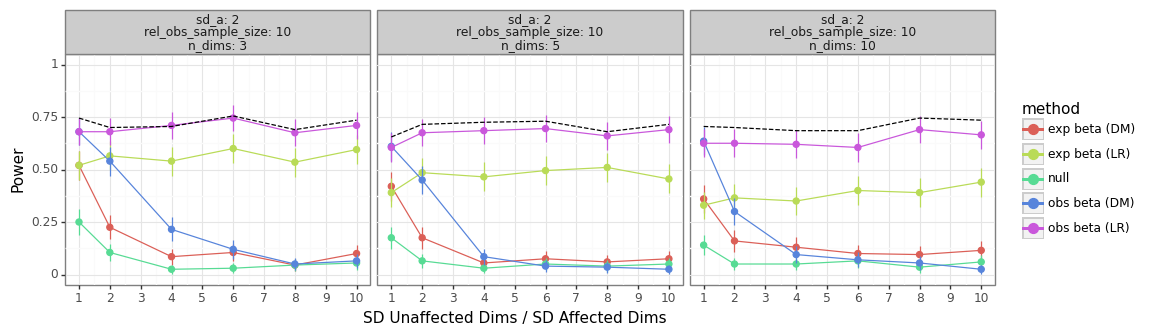

<ggplot: (8766827655745)>

In [ ]:
(
    p9.ggplot(agg_results.query('method != "oracle"'), p9.aes(x='sd_u', y='stat_sig', ymin='lb', ymax='ub', color='method')) + 
    p9.facet_wrap('~sd_a+rel_obs_sample_size+n_dims', labeller='label_both') + p9.geom_line() + p9.geom_pointrange() +
    p9.coord_cartesian(xlim=(1,10)) + p9.theme(figure_size=(12, 3)) +
    p9.scale_x_continuous(labels=range(11), breaks=range(11), name="SD Unaffected Dims / SD Affected Dims") +
    p9.scale_y_continuous(limits=(0,1), name="Power") + 
    p9.geom_line(data=agg_results.query('method == "oracle"'), color="black", linetype="dashed")
)

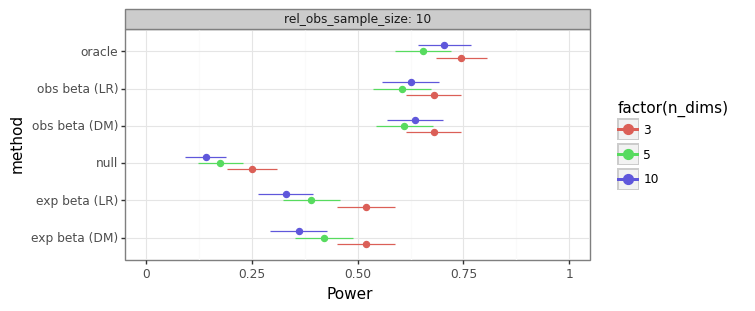

<ggplot: (8766861135794)>

In [ ]:
# Just equal SD results
(
    p9.ggplot(agg_results.query('sd_u==1'), p9.aes(x='method', y='stat_sig', ymin='lb', ymax='ub', color='factor(n_dims)')) + 
    p9.facet_wrap('~rel_obs_sample_size', labeller='label_both') + p9.geom_pointrange(position=p9.position_dodge(0.5)) +
    p9.theme(figure_size=(6, 3)) +
    p9.scale_y_continuous(limits=(0,1), name="Power") +
    p9.coord_flip()
)

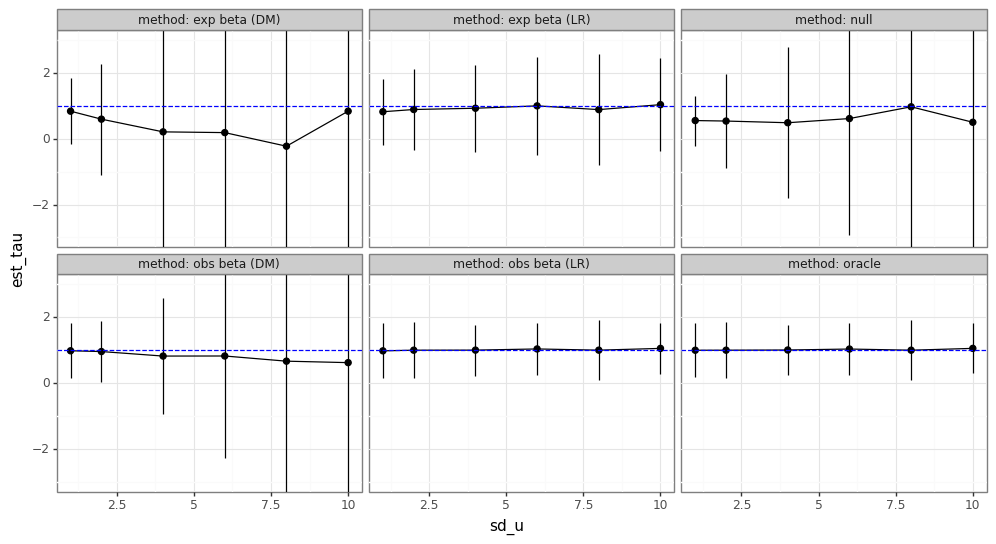

<ggplot: (8766835643365)>

In [ ]:
(
    p9.ggplot(results_df.query("n_dims == 3"), p9.aes(x='sd_u', y='est_tau')) + 
    p9.facet_wrap('~method', labeller='label_both', ncol=3) +
    p9.coord_cartesian(xlim=(1,10), ylim=(-3,3)) + p9.theme(figure_size=(12, 6)) +
    # p9.scale_x_continuous(labels=range(11), breaks=range(11), name="SD Unaffected Dims / SD Affected Dims") +
    # p9.scale_y_continuous(limits=(0,2), name="Est Alpha") + 
    p9.stat_summary(fun_data='mean_sdl', fun_args={'mult':1.96}, geom='pointrange', position=p9.position_dodge(0.5)) + p9.stat_summary(fun_data='mean_sdl', geom='line') +
    p9.geom_hline(yintercept=1, linetype="dashed", color="blue")
)